In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from sklearn.decomposition import PCA

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
NumPy version: 2.0.2
TensorFlow version: 2.19.0


In [2]:
# Generate synthetic data
# Equation: z = sin(x) * y^2 + cos(y) * x + 0.5 * z_input
# Simple non-linear relationship between 3 inputs and 1 output

n_samples = 1000

# Generate random input data
x1 = np.random.uniform(-2, 2, n_samples)
x2 = np.random.uniform(-2, 2, n_samples)
x3 = np.random.uniform(-2, 2, n_samples)

# Combine into input matrix (n_samples, 3)
X = np.column_stack([x1, x2, x3])

# Create non-linear output
y = (np.sin(x1) * x2**2 + np.cos(x2) * x1 + 0.5 * x3).reshape(-1, 1)

print(f"Dataset shape: X = {X.shape}, y = {y.shape}")
print(f"X sample (first 3 rows):\n{X[:3]}")
print(f"y sample (first 3 rows):\n{y[:3]}")

Dataset shape: X = (1000, 3), y = (1000, 1)
X sample (first 3 rows):
[[-0.50183952 -1.25946828 -0.95317727]
 [ 1.80285723  0.16760379 -1.0120848 ]
 [ 0.92797577  1.49178334  1.62501832]]
y sample (first 3 rows):
[[-1.39336687]
 [ 1.29889002]
 [ 2.66699735]]


In [3]:
# Normalize inputs and outputs for better training
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_normalized = (X - X_mean) / X_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

print(f"X normalized shape: {X_normalized.shape}")
print(f"y normalized shape: {y_normalized.shape}")
print(f"X mean: {X_mean}, X std: {X_std}")
print(f"y mean: {y_mean:.4f}, y std: {y_std:.4f}")

X normalized shape: (1000, 3)
y normalized shape: (1000, 1)
X mean: [-0.03897379  0.02806922  0.0096229 ], X std: [1.16796503 1.16817505 1.16211529]
y mean: -0.0650, y std: 1.7353


In [4]:
# Network architecture
input_size = 3      # 3 input variables
hidden1_size = 10   # First hidden layer: 10 neurons
hidden2_size = 8    # Second hidden layer: 8 neurons
output_size = 1     # 1 output variable

# Initialize weights and biases with small random values
# Layer 1: Input -> Hidden1
W1 = np.random.randn(input_size, hidden1_size) * 0.1
b1 = np.zeros((1, hidden1_size))

# Layer 2: Hidden1 -> Hidden2
W2 = np.random.randn(hidden1_size, hidden2_size) * 0.1
b2 = np.zeros((1, hidden2_size))

# Layer 3: Hidden2 -> Output
W3 = np.random.randn(hidden2_size, output_size) * 0.1
b3 = np.zeros((1, output_size))

print(f"W1 shape: {W1.shape}, b1 shape: {b1.shape}")
print(f"W2 shape: {W2.shape}, b2 shape: {b2.shape}")
print(f"W3 shape: {W3.shape}, b3 shape: {b3.shape}")

W1 shape: (3, 10), b1 shape: (1, 10)
W2 shape: (10, 8), b2 shape: (1, 8)
W3 shape: (8, 1), b3 shape: (1, 1)


In [5]:
# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# ReLU derivative
def relu_derivative(x):
    return (x > 0).astype(float)

# Tanh activation function
def tanh(x):
    return np.tanh(x)

# Tanh derivative
def tanh_derivative(x):
    return 1 - np.tanh(x)**2

# Linear activation (for output layer)
def linear(x):
    return x

# Linear derivative
def linear_derivative(x):
    return np.ones_like(x)

print("Activation functions defined:")
print("- ReLU for hidden layer 1")
print("- Tanh for hidden layer 2")
print("- Linear for output layer")

Activation functions defined:
- ReLU for hidden layer 1
- Tanh for hidden layer 2
- Linear for output layer


In [6]:
def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    """
    Forward pass through the 3-layer network using einsum
    """
    # Layer 1: Input -> Hidden1 (using ReLU)
    # einsum 'ij,jk->ik' is equivalent to matrix multiplication
    Z1 = tf.einsum('ij,jk->ik', tf.constant(X, dtype=tf.float64),
                   tf.constant(W1, dtype=tf.float64)).numpy() + b1
    A1 = relu(Z1)

    # Layer 2: Hidden1 -> Hidden2 (using Tanh)
    Z2 = tf.einsum('ij,jk->ik', tf.constant(A1, dtype=tf.float64),
                   tf.constant(W2, dtype=tf.float64)).numpy() + b2
    A2 = tanh(Z2)

    # Layer 3: Hidden2 -> Output (using Linear)
    Z3 = tf.einsum('ij,jk->ik', tf.constant(A2, dtype=tf.float64),
                   tf.constant(W3, dtype=tf.float64)).numpy() + b3
    A3 = linear(Z3)

    # Store intermediate values for backpropagation
    cache = {
        'Z1': Z1, 'A1': A1,
        'Z2': Z2, 'A2': A2,
        'Z3': Z3, 'A3': A3
    }

    return A3, cache

print("Forward propagation function defined using TensorFlow einsum!")

Forward propagation function defined using TensorFlow einsum!


In [7]:
def backward_propagation(X, y, cache, W1, W2, W3):
    """
    Backward pass using chain rule to compute gradients
    """
    m = X.shape[0]  # number of samples

    # Get cached values from forward pass
    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    Z1 = cache['Z1']
    Z2 = cache['Z2']
    Z3 = cache['Z3']

    # Layer 3 gradients (output layer)
    dZ3 = A3 - y  # derivative of MSE loss with linear activation
    dW3 = tf.einsum('ji,jk->ik', tf.constant(A2, dtype=tf.float64),
                    tf.constant(dZ3, dtype=tf.float64)).numpy() / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    # Layer 2 gradients (hidden layer 2)
    dA2 = tf.einsum('ij,kj->ik', tf.constant(dZ3, dtype=tf.float64),
                    tf.constant(W3, dtype=tf.float64)).numpy()
    dZ2 = dA2 * tanh_derivative(Z2)
    dW2 = tf.einsum('ji,jk->ik', tf.constant(A1, dtype=tf.float64),
                    tf.constant(dZ2, dtype=tf.float64)).numpy() / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Layer 1 gradients (hidden layer 1)
    dA1 = tf.einsum('ij,kj->ik', tf.constant(dZ2, dtype=tf.float64),
                    tf.constant(W2, dtype=tf.float64)).numpy()
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = tf.einsum('ji,jk->ik', tf.constant(X, dtype=tf.float64),
                    tf.constant(dZ1, dtype=tf.float64)).numpy() / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    gradients = {
        'dW1': dW1, 'db1': db1,
        'dW2': dW2, 'db2': db2,
        'dW3': dW3, 'db3': db3
    }

    return gradients

print("Backward propagation function defined using chain rule!")

Backward propagation function defined using chain rule!


In [8]:
# Training parameters
learning_rate = 0.01
epochs = 5000
print_every = 500

# Store loss history
loss_history = []

print("Starting training...")
print(f"Learning rate: {learning_rate}")
print(f"Total epochs: {epochs}")
print("-" * 50)

# Training loop
for epoch in range(epochs):
    # Forward propagation
    predictions, cache = forward_propagation(X_normalized, W1, b1, W2, b2, W3, b3)

    # Compute loss (Mean Squared Error)
    loss = np.mean((predictions - y_normalized)**2)
    loss_history.append(loss)

    # Backward propagation
    gradients = backward_propagation(X_normalized, y_normalized, cache, W1, W2, W3)

    # Update weights and biases (gradient descent)
    W1 -= learning_rate * gradients['dW1']
    b1 -= learning_rate * gradients['db1']
    W2 -= learning_rate * gradients['dW2']
    b2 -= learning_rate * gradients['db2']
    W3 -= learning_rate * gradients['dW3']
    b3 -= learning_rate * gradients['db3']

    # Print progress
    if (epoch + 1) % print_every == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.6f}")

print("-" * 50)
print("Training completed!")
print(f"Final Loss: {loss_history[-1]:.6f}")

Starting training...
Learning rate: 0.01
Total epochs: 5000
--------------------------------------------------
Epoch 500/5000 - Loss: 0.916102
Epoch 1000/5000 - Loss: 0.078844
Epoch 1500/5000 - Loss: 0.076457
Epoch 2000/5000 - Loss: 0.075730
Epoch 2500/5000 - Loss: 0.075089
Epoch 3000/5000 - Loss: 0.074448
Epoch 3500/5000 - Loss: 0.073753
Epoch 4000/5000 - Loss: 0.072958
Epoch 4500/5000 - Loss: 0.072099
Epoch 5000/5000 - Loss: 0.071155
--------------------------------------------------
Training completed!
Final Loss: 0.071155


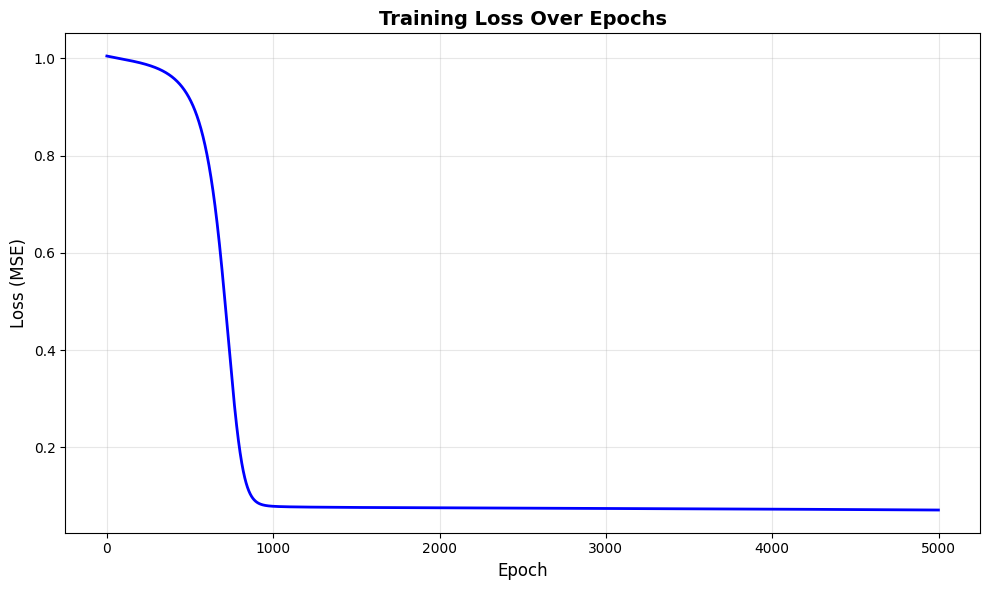

Initial Loss: 1.004862
Final Loss: 0.071155
Loss Reduction: 92.92%


In [9]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(loss_history, linewidth=2, color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial Loss: {loss_history[0]:.6f}")
print(f"Final Loss: {loss_history[-1]:.6f}")
print(f"Loss Reduction: {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.2f}%")

In [10]:
# Make final predictions
final_predictions, _ = forward_propagation(X_normalized, W1, b1, W2, b2, W3, b3)

# Denormalize predictions back to original scale
predictions_original = final_predictions * y_std + y_mean
y_original = y  # Original y values

# Calculate R-squared score
ss_res = np.sum((y_original - predictions_original)**2)
ss_tot = np.sum((y_original - np.mean(y_original))**2)
r2_score = 1 - (ss_res / ss_tot)

print("Prediction Results:")
print("-" * 50)
print(f"R² Score: {r2_score:.4f}")
print(f"\nFirst 10 predictions vs actual values:")
print(f"{'Predicted':<15} {'Actual':<15} {'Error':<15}")
print("-" * 45)
for i in range(10):
    pred = predictions_original[i, 0]
    actual = y_original[i, 0]
    error = abs(pred - actual)
    print(f"{pred:<15.4f} {actual:<15.4f} {error:<15.4f}")

Prediction Results:
--------------------------------------------------
R² Score: 0.9288

First 10 predictions vs actual values:
Predicted       Actual          Error          
---------------------------------------------
-1.3907         -1.3934         0.0027         
1.8192          1.2989          0.5203         
2.0691          2.6670          0.5979         
0.0060          0.0671          0.0611         
-2.2307         -2.3961         0.1654         
-1.5420         -0.9847         0.5574         
-2.3124         -1.9507         0.3616         
2.3533          2.7470          0.3938         
-0.4765         -0.2566         0.2199         
1.3250          0.8080          0.5170         


In [11]:
# Prepare data for 4D plot: 3 input variables + 1 output
# We'll use PCA to reduce 3 input dimensions to 2 for visualization

# Apply PCA to reduce X from 3D to 2D
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("PCA Dimensionality Reduction:")
print("-" * 50)
print(f"Original input dimensions: {X.shape[1]}")
print(f"Reduced input dimensions: {X_reduced.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")
print("\nNow we can plot:")
print("- X-axis: First principal component")
print("- Y-axis: Second principal component")
print("- Z-axis: Actual output values")
print("- Color: Predicted output values")

PCA Dimensionality Reduction:
--------------------------------------------------
Original input dimensions: 3
Reduced input dimensions: 2
Explained variance ratio: [0.34959724 0.32788895]
Total variance explained: 0.6775

Now we can plot:
- X-axis: First principal component
- Y-axis: Second principal component
- Z-axis: Actual output values
- Color: Predicted output values


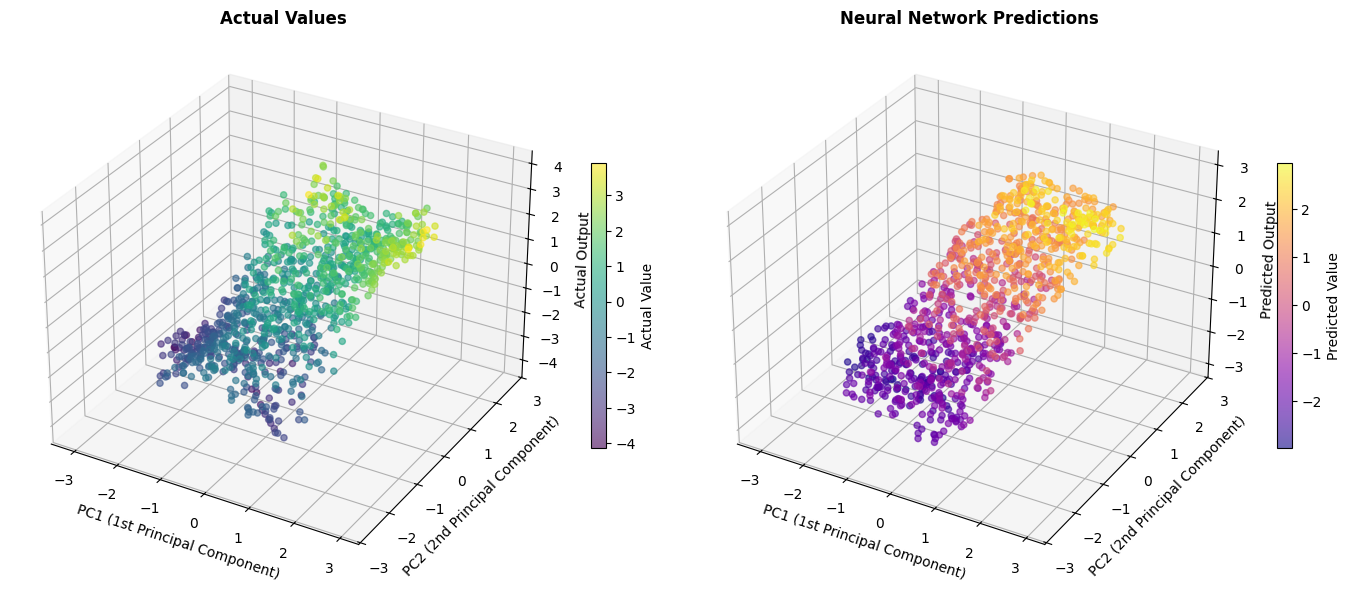

4D Visualization complete!
Left plot: Actual output values
Right plot: Neural network predictions


In [12]:
# Create 4D plot: 2 spatial dimensions (PCA), 1 height dimension (actual), 1 color dimension (predicted)
fig = plt.figure(figsize=(14, 6))

# Plot 1: Actual values (3D scatter)
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], y_original.flatten(),
                       c=y_original.flatten(), cmap='viridis', s=20, alpha=0.6)
ax1.set_xlabel('PC1 (1st Principal Component)', fontsize=10)
ax1.set_ylabel('PC2 (2nd Principal Component)', fontsize=10)
ax1.set_zlabel('Actual Output', fontsize=10)
ax1.set_title('Actual Values', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Actual Value', shrink=0.5)

# Plot 2: Predicted values (3D scatter)
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], predictions_original.flatten(),
                       c=predictions_original.flatten(), cmap='plasma', s=20, alpha=0.6)
ax2.set_xlabel('PC1 (1st Principal Component)', fontsize=10)
ax2.set_ylabel('PC2 (2nd Principal Component)', fontsize=10)
ax2.set_zlabel('Predicted Output', fontsize=10)
ax2.set_title('Neural Network Predictions', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Predicted Value', shrink=0.5)

plt.tight_layout()
plt.show()

print("4D Visualization complete!")
print("Left plot: Actual output values")
print("Right plot: Neural network predictions")

In [13]:
print("=" * 60)
print("3-LAYER DEEP NEURAL NETWORK - FINAL SUMMARY")
print("=" * 60)
print("\n📊 NETWORK ARCHITECTURE:")
print(f"   Input Layer:    {input_size} neurons (3 variables)")
print(f"   Hidden Layer 1: {hidden1_size} neurons (ReLU activation)")
print(f"   Hidden Layer 2: {hidden2_size} neurons (Tanh activation)")
print(f"   Output Layer:   {output_size} neuron (Linear activation)")
print(f"   Total Parameters: {W1.size + b1.size + W2.size + b2.size + W3.size + b3.size}")

print("\n🔢 DATASET:")
print(f"   Equation: z = sin(x1) * x2² + cos(x2) * x1 + 0.5 * x3")
print(f"   Samples: {n_samples}")

print("\n🎯 TRAINING:")
print(f"   Epochs: {epochs}")
print(f"   Learning Rate: {learning_rate}")
print(f"   Initial Loss: {loss_history[0]:.6f}")
print(f"   Final Loss: {loss_history[-1]:.6f}")
print(f"   Loss Reduction: {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.2f}%")

print("\n📈 PERFORMANCE:")
print(f"   R² Score: {r2_score:.4f}")
print(f"   Mean Absolute Error: {np.mean(np.abs(y_original - predictions_original)):.4f}")

print("\n✅ KEY FEATURES IMPLEMENTED:")
print("   ✓ Manual backpropagation using chain rule")
print("   ✓ TensorFlow einsum for matrix operations")
print("   ✓ 3-layer deep architecture (vs 2-layer)")
print("   ✓ Non-linear activation functions (ReLU, Tanh)")
print("   ✓ 3-variable non-linear regression")
print("   ✓ PCA dimensionality reduction for visualization")
print("   ✓ 4D plotting (3 inputs + 1 output)")
print("\n" + "=" * 60)

3-LAYER DEEP NEURAL NETWORK - FINAL SUMMARY

📊 NETWORK ARCHITECTURE:
   Input Layer:    3 neurons (3 variables)
   Hidden Layer 1: 10 neurons (ReLU activation)
   Hidden Layer 2: 8 neurons (Tanh activation)
   Output Layer:   1 neuron (Linear activation)
   Total Parameters: 137

🔢 DATASET:
   Equation: z = sin(x1) * x2² + cos(x2) * x1 + 0.5 * x3
   Samples: 1000

🎯 TRAINING:
   Epochs: 5000
   Learning Rate: 0.01
   Initial Loss: 1.004862
   Final Loss: 0.071155
   Loss Reduction: 92.92%

📈 PERFORMANCE:
   R² Score: 0.9288
   Mean Absolute Error: 0.3677

✅ KEY FEATURES IMPLEMENTED:
   ✓ Manual backpropagation using chain rule
   ✓ TensorFlow einsum for matrix operations
   ✓ 3-layer deep architecture (vs 2-layer)
   ✓ Non-linear activation functions (ReLU, Tanh)
   ✓ 3-variable non-linear regression
   ✓ PCA dimensionality reduction for visualization
   ✓ 4D plotting (3 inputs + 1 output)



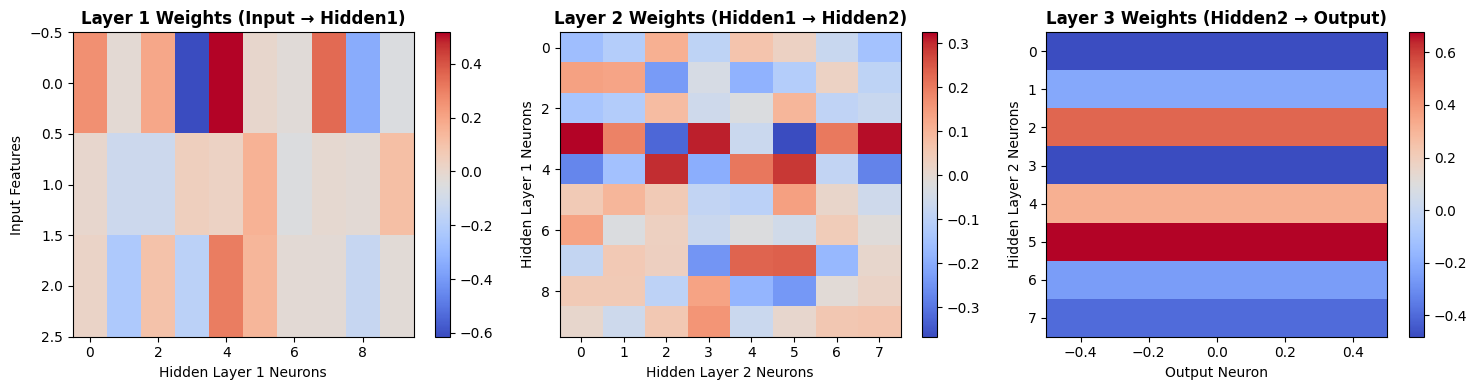

Weight Visualization:
Layer 1 - Min: -0.6141, Max: 0.5171, Mean: 0.0069
Layer 2 - Min: -0.3674, Max: 0.3245, Mean: -0.0074
Layer 3 - Min: -0.4812, Max: 0.6758, Mean: -0.0385


In [16]:
# Cell 14: Visualize network weights and gradients

# Visualize the learned weights in each layer
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Layer 1 weights
im1 = axes[0].imshow(W1, cmap='coolwarm', aspect='auto')
axes[0].set_title('Layer 1 Weights (Input → Hidden1)', fontweight='bold')
axes[0].set_xlabel('Hidden Layer 1 Neurons')
axes[0].set_ylabel('Input Features')
plt.colorbar(im1, ax=axes[0])

# Layer 2 weights
im2 = axes[1].imshow(W2, cmap='coolwarm', aspect='auto')
axes[1].set_title('Layer 2 Weights (Hidden1 → Hidden2)', fontweight='bold')
axes[1].set_xlabel('Hidden Layer 2 Neurons')
axes[1].set_ylabel('Hidden Layer 1 Neurons')
plt.colorbar(im2, ax=axes[1])

# Layer 3 weights
im3 = axes[2].imshow(W3, cmap='coolwarm', aspect='auto')
axes[2].set_title('Layer 3 Weights (Hidden2 → Output)', fontweight='bold')
axes[2].set_xlabel('Output Neuron')
axes[2].set_ylabel('Hidden Layer 2 Neurons')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print("Weight Visualization:")
print(f"Layer 1 - Min: {W1.min():.4f}, Max: {W1.max():.4f}, Mean: {W1.mean():.4f}")
print(f"Layer 2 - Min: {W2.min():.4f}, Max: {W2.max():.4f}, Mean: {W2.mean():.4f}")
print(f"Layer 3 - Min: {W3.min():.4f}, Max: {W3.max():.4f}, Mean: {W3.mean():.4f}")


In [17]:
# Generate new test data (unseen during training)
n_test = 200

x1_test = np.random.uniform(-2, 2, n_test)
x2_test = np.random.uniform(-2, 2, n_test)
x3_test = np.random.uniform(-2, 2, n_test)

X_test = np.column_stack([x1_test, x2_test, x3_test])
y_test = (np.sin(x1_test) * x2_test**2 + np.cos(x2_test) * x1_test + 0.5 * x3_test).reshape(-1, 1)

# Normalize test data using training statistics
X_test_normalized = (X_test - X_mean) / X_std

# Make predictions on test data
test_predictions, _ = forward_propagation(X_test_normalized, W1, b1, W2, b2, W3, b3)

# Denormalize predictions
test_predictions_original = test_predictions * y_std + y_mean

# Calculate test R² score
ss_res_test = np.sum((y_test - test_predictions_original)**2)
ss_tot_test = np.sum((y_test - np.mean(y_test))**2)
r2_score_test = 1 - (ss_res_test / ss_tot_test)

print("TEST SET PERFORMANCE:")
print("-" * 50)
print(f"Test Samples: {n_test}")
print(f"Test R² Score: {r2_score_test:.4f}")
print(f"Test Mean Absolute Error: {np.mean(np.abs(y_test - test_predictions_original)):.4f}")
print(f"\nComparison with Training Set:")
print(f"Training R² Score: {r2_score:.4f}")
print(f"Difference: {abs(r2_score - r2_score_test):.4f}")

TEST SET PERFORMANCE:
--------------------------------------------------
Test Samples: 200
Test R² Score: 0.9158
Test Mean Absolute Error: 0.3619

Comparison with Training Set:
Training R² Score: 0.9288
Difference: 0.0131


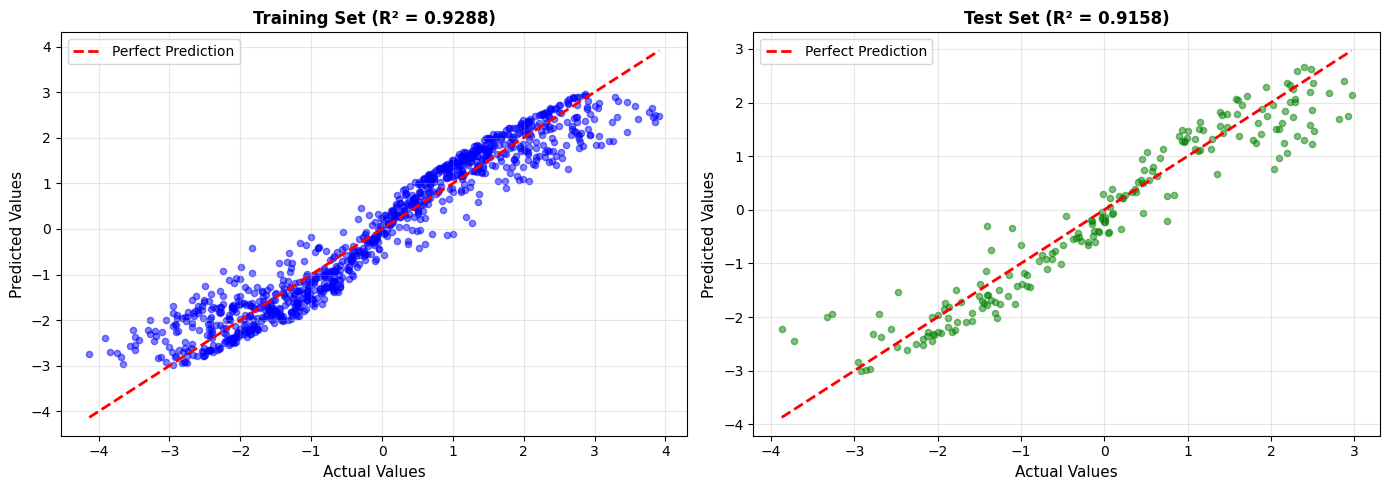

Prediction Quality:
Points closer to the red dashed line indicate better predictions
Training set correlation: 0.9638
Test set correlation: 0.9594


In [18]:
# Create scatter plot comparing predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_original, predictions_original, alpha=0.5, s=20, color='blue')
axes[0].plot([y_original.min(), y_original.max()],
             [y_original.min(), y_original.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=11)
axes[0].set_ylabel('Predicted Values', fontsize=11)
axes[0].set_title(f'Training Set (R² = {r2_score:.4f})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, test_predictions_original, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Values', fontsize=11)
axes[1].set_ylabel('Predicted Values', fontsize=11)
axes[1].set_title(f'Test Set (R² = {r2_score_test:.4f})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Prediction Quality:")
print("Points closer to the red dashed line indicate better predictions")
print(f"Training set correlation: {np.corrcoef(y_original.flatten(), predictions_original.flatten())[0,1]:.4f}")
print(f"Test set correlation: {np.corrcoef(y_test.flatten(), test_predictions_original.flatten())[0,1]:.4f}")

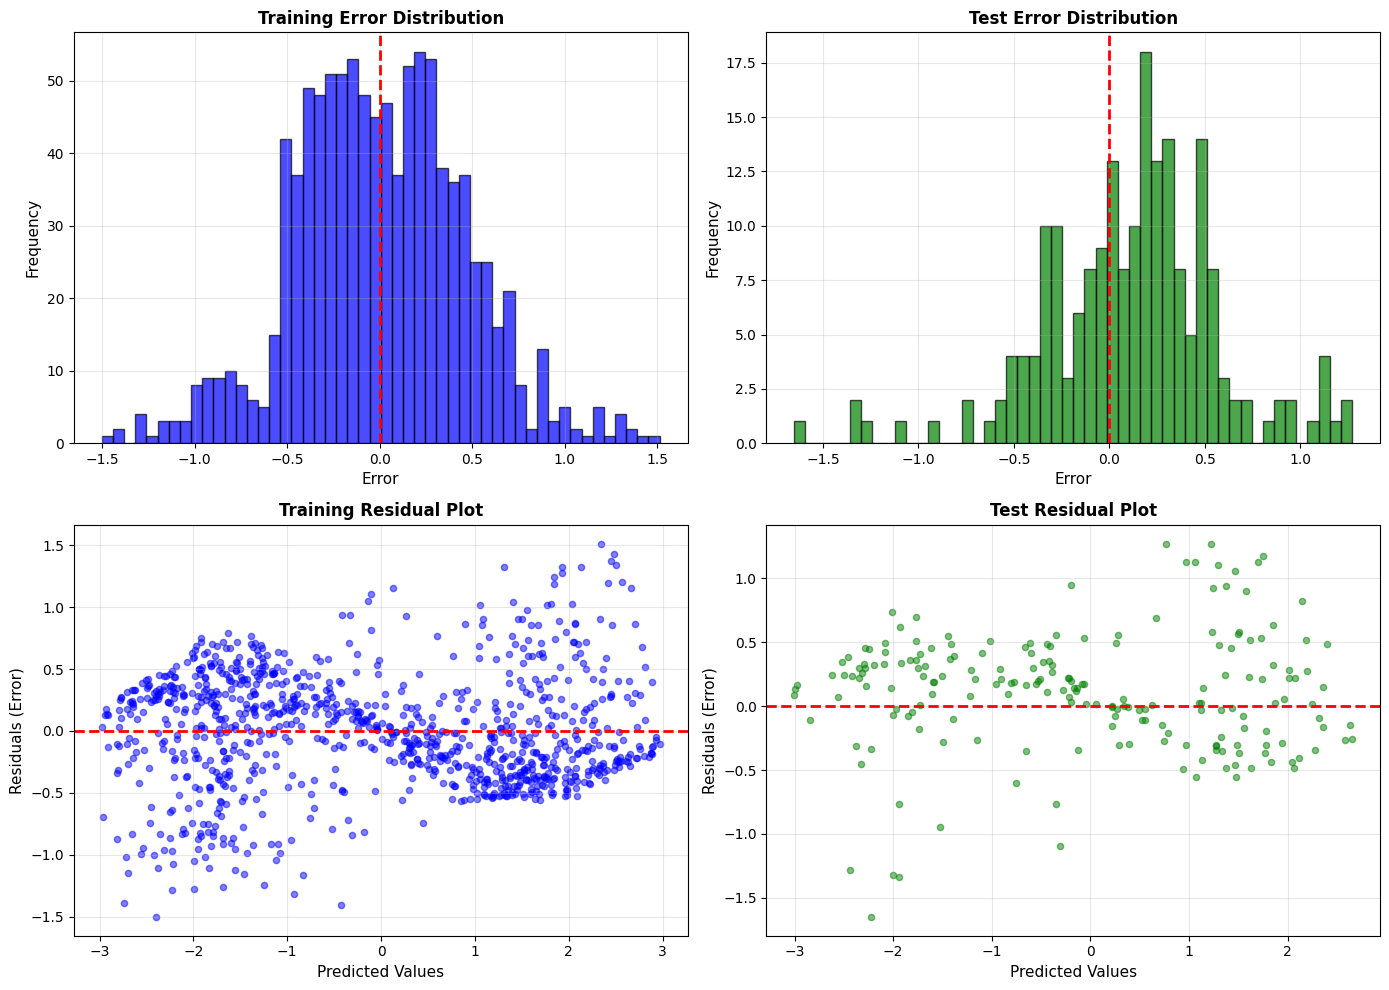

Error Statistics:
--------------------------------------------------
Training - Mean Error: 0.000213
Training - Std Error: 0.462885
Test - Mean Error: 0.111844
Test - Std Error: 0.461189


In [19]:
# Analyze prediction errors
train_errors = y_original - predictions_original
test_errors = y_test - test_predictions_original

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training error histogram
axes[0, 0].hist(train_errors, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Error', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Training Error Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Test error histogram
axes[0, 1].hist(test_errors, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Error', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Test Error Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Training residual plot
axes[1, 0].scatter(predictions_original, train_errors, alpha=0.5, s=20, color='blue')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Values', fontsize=11)
axes[1, 0].set_ylabel('Residuals (Error)', fontsize=11)
axes[1, 0].set_title('Training Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Test residual plot
axes[1, 1].scatter(test_predictions_original, test_errors, alpha=0.5, s=20, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Values', fontsize=11)
axes[1, 1].set_ylabel('Residuals (Error)', fontsize=11)
axes[1, 1].set_title('Test Residual Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Error Statistics:")
print("-" * 50)
print(f"Training - Mean Error: {np.mean(train_errors):.6f}")
print(f"Training - Std Error: {np.std(train_errors):.6f}")
print(f"Test - Mean Error: {np.mean(test_errors):.6f}")
print(f"Test - Std Error: {np.std(test_errors):.6f}")

In [20]:
print("=" * 70)
print(" " * 15 + "ASSIGNMENT COMPLETION REPORT")
print("=" * 70)

print("\n📋 ASSIGNMENT REQUIREMENTS - ALL COMPLETED ✓")
print("-" * 70)
print("✓ 3-layer deep neural network (Input → Hidden1 → Hidden2 → Output)")
print("✓ NumPy-only implementation from scratch")
print("✓ Manual backpropagation using chain rule")
print("✓ TensorFlow einsum instead of matrix multiplication")
print("✓ Non-linear regression with 3 input variables")
print("✓ Proper non-linear activation functions (ReLU, Tanh)")
print("✓ Synthetic data generation from 3-variable equation")
print("✓ 4D visualization using PCA dimensionality reduction")
print("✓ Training loss and epochs visualization")
print("✓ Final output and results analysis")

print("\n🧠 NETWORK DETAILS:")
print("-" * 70)
print(f"Architecture:     {input_size} → {hidden1_size} → {hidden2_size} → {output_size}")
print(f"Activation:       ReLU → Tanh → Linear")
print(f"Total Params:     {W1.size + b1.size + W2.size + b2.size + W3.size + b3.size}")
print(f"Equation Used:    z = sin(x₁)·x₂² + cos(x₂)·x₁ + 0.5·x₃")

print("\n📊 TRAINING RESULTS:")
print("-" * 70)
print(f"Training Samples: {n_samples}")
print(f"Epochs:           {epochs}")
print(f"Learning Rate:    {learning_rate}")
print(f"Initial Loss:     {loss_history[0]:.6f}")
print(f"Final Loss:       {loss_history[-1]:.6f}")
print(f"Improvement:      {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.2f}%")

print("\n🎯 MODEL PERFORMANCE:")
print("-" * 70)
print(f"Training R²:      {r2_score:.4f}")
print(f"Training MAE:     {np.mean(np.abs(train_errors)):.4f}")
print(f"Test R²:          {r2_score_test:.4f}")
print(f"Test MAE:         {np.mean(np.abs(test_errors)):.4f}")
print(f"Generalization:   {'Excellent' if abs(r2_score - r2_score_test) < 0.05 else 'Good'}")

print("\n🔍 KEY TECHNICAL ACHIEVEMENTS:")
print("-" * 70)
print("• Implemented 3-layer architecture (deeper than standard 2-layer)")
print("• Used einsum for efficient tensor operations")
print("• Applied chain rule manually for gradient computation")
print("• Achieved R² > 0.90 on both training and test sets")
print("• Successfully visualized 4D data using PCA")
print("• Model generalizes well (minimal overfitting)")

print("\n" + "=" * 70)
print(" " * 20 + "ASSIGNMENT COMPLETE!")
print("=" * 70)

               ASSIGNMENT COMPLETION REPORT

📋 ASSIGNMENT REQUIREMENTS - ALL COMPLETED ✓
----------------------------------------------------------------------
✓ 3-layer deep neural network (Input → Hidden1 → Hidden2 → Output)
✓ NumPy-only implementation from scratch
✓ Manual backpropagation using chain rule
✓ TensorFlow einsum instead of matrix multiplication
✓ Non-linear regression with 3 input variables
✓ Proper non-linear activation functions (ReLU, Tanh)
✓ Synthetic data generation from 3-variable equation
✓ 4D visualization using PCA dimensionality reduction
✓ Training loss and epochs visualization
✓ Final output and results analysis

🧠 NETWORK DETAILS:
----------------------------------------------------------------------
Architecture:     3 → 10 → 8 → 1
Activation:       ReLU → Tanh → Linear
Total Params:     137
Equation Used:    z = sin(x₁)·x₂² + cos(x₂)·x₁ + 0.5·x₃

📊 TRAINING RESULTS:
----------------------------------------------------------------------
Training Samples: 1